<a href="https://colab.research.google.com/github/alu0100880755/Logistica/blob/master/TSP_6%20(Ventanas%20Temporales).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


TIEMPOS

	Tiempos iniciales: [1714, 831, 936, 1077, 1203]

	Tiempos finales: [1714, 1526, 1073, 1136, 1776]

	Tiempos de servicio: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}

	Tiempos de ruta: {(0, 1): 100, (0, 2): 100, (0, 3): 100, (0, 4): 100, (1, 0): 100, (1, 2): 100, (1, 3): 100, (1, 4): 100, (2, 0): 100, (2, 1): 100, (2, 3): 100, (2, 4): 100, (3, 0): 100, (3, 1): 100, (3, 2): 100, (3, 4): 100, (4, 0): 100, (4, 1): 100, (4, 2): 100, (4, 3): 100}


RUTA

	Distancia total de la ruta =  311.0 kilómetros

	Costos de distancia mínima:

		De 0 a 2 con distancia = 71 Km
		De 1 a 4 con distancia = 36 Km
		De 2 a 3 con distancia = 49 Km
		De 3 a 1 con distancia = 72 Km
		De 4 a 0 con distancia = 83 Km

	Orden de la ruta de distancia mínima:

	 0--> 2--> 3--> 1--> 4--> 0

DATOS DE INTERÉS

	Tiempo Empleado:  43  milisegundos, |  0.04  segundos |  0.0  minutos 
	Iteraciones:  135
	Nodos:  0

DIBUJO DE LA RUTA


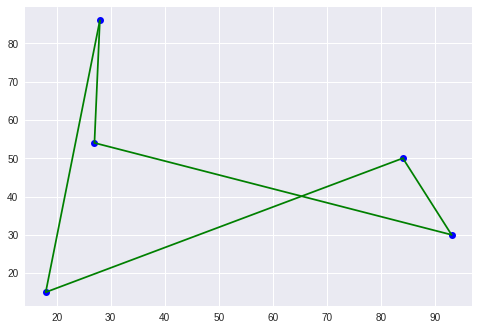

In [3]:
#Instalamos lo necesario
!pip install ortools
from ortools.linear_solver import pywraplp

#Importamos las librerías necesarias
import random
import math
import matplotlib.pyplot as plt
import json

#Declaramos las constantes
nodos = 5
todos = range(nodos)
otros = range(1,nodos)

#Precisión
EPS = 0.001

#Semilla para que empiece por un punto similar siempre y poder comparar con varios modelos
random.seed(8880)

dist= { (i,j) : random.randint(1,100) for i in todos for j in todos if i!=j}

#Arcos óptimos para el posterior muestreo
dist_final = { }

###########
# TIEMPOS #
###########

# Tiempos iniciales
e = []
for i in todos:
    e.append(random.randint(800,1900))

# Tiempos finales
l = []
for i in todos:
    aux = random.randint(900,2000)
    while aux <= e[i]:
        aux = random.randint(900,2000)
    l.append(aux)
    
e[0] = l[0]

# #Ejemplo manual
# e = [1500, 1000, 1300, 900, 800]
# l = [1500, 1300, 1500, 1200, 1100]


# Tiempos de servicio
s ={i: 100 for i in todos}

# Tiempos de ruta
t = {(i,j): 100 for i in todos for j in todos if i!=j}



print("\nTIEMPOS")
print("\n\tTiempos iniciales: " + str(e))
print("\n\tTiempos finales: " + str(l))
print("\n\tTiempos de servicio: " + str(s))
print("\n\tTiempos de ruta: " + str(t))

########


#####################################################################################
#DIBUJAR LOS RESULTADOS

def dibuja(selected):
    points = [(random.randint(0,100),random.randint(0,100)) for i in todos]

    plt.plot([p[0] for p in points], [p[1] for p in points], 'bo')
    for (i,j) in selected:
        plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'g-')


#####################################################################################


#TSP con ventanas temporales
def TSP_6():
    solver = pywraplp.Solver('TSP', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    #VARIABLES
      
    #Arcos elegidos (Ruta)
    x = {}
    for i in todos:
        for j in todos:
            if i!=j:
                x[i, j] = solver.BoolVar('x[%i, %i]' % (i, j))
    
    #Numero de bicis que llevamos
    u = {}
    for i in otros:
        u[i] = solver.IntVar(1.0, solver.infinity(), 'u[%i]' % (i))    
    
    #Función objetivo
    solver.Minimize(solver.Sum([dist[i,j]*x[i,j] for i in todos for j in todos if i!=j]))

    
    #Restricciones
    [ solver.Add(  solver.Sum(x[i,j] for j in todos if i!=j) == 1  )  for i in todos ]
    [ solver.Add(  solver.Sum(x[j,i] for j in todos if i!=j) == 1  )  for i in todos ]  
    [ solver.Add(   e[i] <= u[i] <= l[i] ) for i in otros  ]    
    [ solver.Add( u[j] >= u[i] + (s[i]+t[i,j]) * x[i,j] - (l[i]-e[j]) * (1-x[i,j]) ) for i in otros for j in otros if i!=j ]
    
    #Resolvemos
    sol = solver.Solve()

    print("\n\nRUTA")
    
    if sol == solver.OPTIMAL:
            print('\n\tDistancia total de la ruta = ', solver.Objective().Value(),'kilómetros')

            #DISTANCIAS ENTRE NODOS
            print('\n\tCostos de distancia mínima:\n')
            for i in todos:
                for j in todos:
                    if i!=j and x[i,j].solution_value() > EPS :
                        print('\t\tDe %d a %d con distancia = %d Km'  % (i,j,dist[i,j]))
                        dist_final.update({ (i, j): dist[i,j] })   #Actualizamos el diccionario con las soluciones

            #ORDEN DE LA RUTA
            print('\n\tOrden de la ruta de distancia mínima:\n')
            ruta = '0'; i = 0

            while i != -1:
                for j in todos:
                    if i!=j:
                        if x[i, j].solution_value() > 0:
                            ruta += '--> ' + str(j)
                            aux = j
                if aux != 0:
                    i = aux
                else:
                    i = -1
            #Mostramos el orden de la ruta
            print("\t", ruta)

            #Muestreo del tiempo
            print("\nDATOS DE INTERÉS")

            milisegundos = solver.WallTime()
            segundos = round((milisegundos/1000),2)
            minutos = round((segundos/60),2)
            print("\n\tTiempo Empleado: ", milisegundos, " milisegundos, | ", segundos , " segundos | ", minutos, " minutos ")
            print("\tIteraciones: ", solver.Iterations())
            print("\tNodos: ", solver.nodes())

    else:
            print('\n\tNo existe solución óptima')

    #DIBUJO DE LA RUTA
    print('\nDIBUJO DE LA RUTA')
    dibuja(dist_final)

#Llamamos a la funcion
TSP_6()        